# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

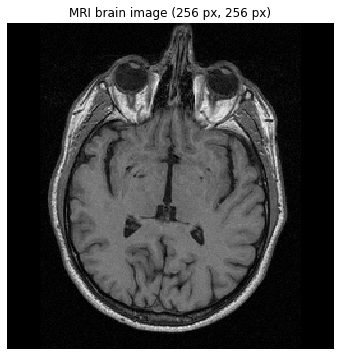

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

### 1.3 Contour detection
Add your implementation and discussion

### 1.4 Additional method(s)
Add your implementation and discussion

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

In [3]:
import scipy.signal as scps
import matplotlib.pyplot as plt

### 2.1 Visualization

In [22]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


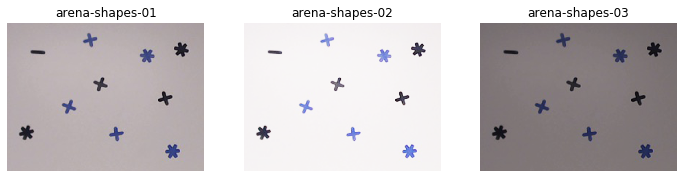

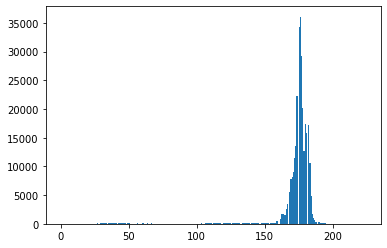

In [23]:
import numpy as np
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()
d=plt.hist((images[0,:,:,2]).ravel(), bins = 256)

### 2.2 Number of shapes of each color
Add your implementation and discussion

In [24]:
#mean of channels of image 1, for ref
means_ch = np.zeros((1,3))
for nb_ch in range(3):
    means_ch[:,nb_ch] = np.mean(images[0,:,:,nb_ch])

#function to change illumination of the image, using the mean computed before
def normalize_image(im, means_ch):
    r_im = im.astype('int16')
    for nb_ch in range(3):
        r_im[:,:,nb_ch] = r_im[:,:,nb_ch] - (np.mean(r_im[:,:,nb_ch]) - means_ch[0,nb_ch])
        r_im[r_im[:,:,nb_ch] >= 256, nb_ch] = 255
        r_im[r_im[:,:,nb_ch] < 0, nb_ch] = 0
    r_im = r_im.astype('uint8')
    return r_im

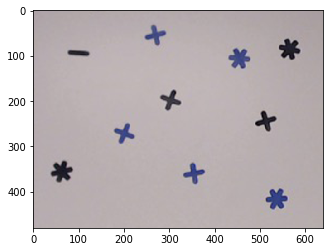

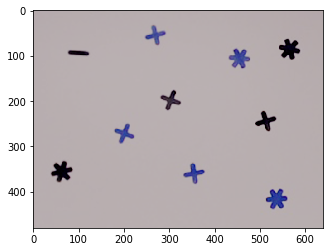

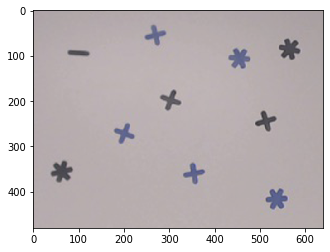

In [25]:
#print normalized images
im1=normalize_image(images[0,:,:,:],means_ch)
a1=plt.imshow(im1)
plt.show()
im2=normalize_image(images[1,:,:,:],means_ch)
a2=plt.imshow(im2)
plt.show()
im3=normalize_image(images[2,:,:,:],means_ch)
a3=plt.imshow(im3)
plt.show()

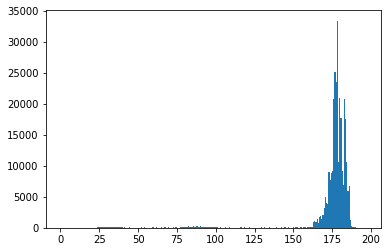

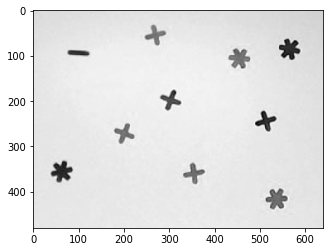

(480, 640)


In [26]:
#print histograms of arena_shapes-01 to determine where to threshold
mean_colours = np.mean(im1, axis=2)
mhist = plt.hist(mean_colours.ravel(), bins=256)
plt.show()
a4=plt.imshow(mean_colours, cmap='gray')
plt.show()
print(mean_colours.shape)

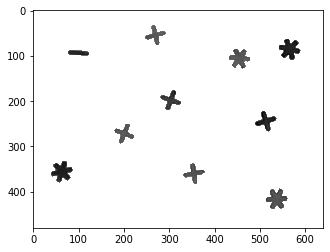

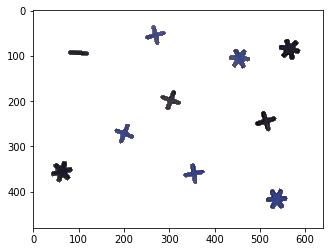

In [27]:
#threshold background
mean_colours[mean_colours>125] = 255 
a4=plt.imshow(mean_colours, cmap='gray')
plt.show()
im1[mean_colours==255,:] = 255
a4=plt.imshow(im1)
plt.show()

In [69]:
#separate each shape

def get_neighbours_coord(line, col, shape):
    neighb = np.array([[-2, -2, -2, -2, -2, -1, 0, 1, 2, 2, 2, 2, 2, 1, 0, -1, -1, -1, -1, 0, 1, 1, 1, 0 ], [-2, -1, 0, 1, 2, 2, 2, 2, 2, 1, 0, -1, -2, -2, -2, -2, -1, 0, 1, 1, 1, 0, -1, -1]])
    neighb[0, :] = neighb[0, :] + line
    neighb[1, :] = neighb[1, :] + col
    neighb_arr = np.zeros(shape, dtype=bool)
    neighb_arr[neighb[0,:], neighb[1,:]] = True
    return neighb_arr

def get_neighbours_coord2(line, col, size, shape):
    neighb = np.zeros(shape, dtype=bool)
    neighb[(line-size):(line+size+1), (col-size):(col+size+1)] = True
    return neighb
    
    
#count regions
shape_num = 1
label = np.zeros(mean_colours.shape)
for lines in range(mean_colours.shape[0]):
    for cols in range(mean_colours.shape[1]):
        if mean_colours[lines, cols] == 255:
            continue
        neighb = get_neighbours_coord2(lines, cols, 10, mean_colours.shape)
        if np.any(mean_colours[neighb] != 255):
            if label[neighb].max() == 0:
                label[np.logical_and(mean_colours != 255, neighb)] = shape_num
                shape_num = shape_num + 1
            else:
                label[np.logical_and(mean_colours != 255, neighb)] = label[neighb].max()
                    
            


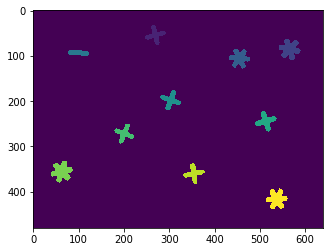

In [70]:
a4=plt.imshow(label)
plt.show()

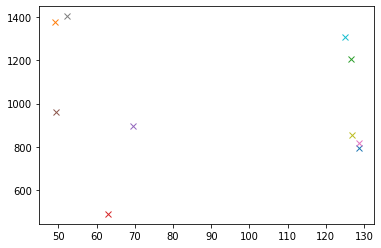

In [83]:
#Determine colour and class of each shape
nb_pix = np.zeros([1,10])
mean_value = np.zeros([1,10])
for i in range(1, 11):
    #check in blue channel
    nb_pix[0,i-1] = im1[label==i,2].shape[0]
    mean_value[0,i-1] = np.mean(im1[label==i,2])
    
    
fig, ax = plt.subplots()
ax.plot(mean_value, nb_pix, 'x')
plt.show()

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion